# NLP

- Networks do not understand raw text so all text has to be encoded.
- Then it needs to be one-hot encoded

# Libraries

In [29]:
import torch
from torch import nn
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# GPU check
torch.cuda.is_available()

True

# Data

## Read data

In [31]:
with open('/content/drive/MyDrive/AI Data/shakespeare.txt','r', encoding='utf8') as f:
    text = f.read()

In [32]:
print(text[:1000])


                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bud buriest thy content,
  And tender churl mak'st waste in niggarding:
    Pity the world, or else this glutton be,
    To eat the world's due, by the grave and thee.


                     2
  When forty winters shall besiege thy brow,
  And dig deep trenches in thy beauty's field,
  Thy youth's proud livery so gazed on now,
  Will be a tattered weed of small worth held:  
  Then being asked, where all thy beauty lies,
  Where all the treasure of thy lusty days;
  To say within thine own deep su

## Encoding text

We will create a set of all characters, assign an id to each character, and build two dictionaries one with id > text, another with text > id

In [33]:
# Create a set of all unique characters in the text
all_characters = set(text)
len(all_characters)

84

In [34]:
# Create a decoder that reads the ID and returns the character.
# Assign an ID to each character and save it in a dictionary
decoder = dict(enumerate(all_characters))
decoder

{0: 'b',
 1: 'W',
 2: 'z',
 3: 'S',
 4: 'r',
 5: 'O',
 6: 'K',
 7: '1',
 8: '3',
 9: 'w',
 10: 'u',
 11: 'U',
 12: '(',
 13: ' ',
 14: 'q',
 15: 'I',
 16: '8',
 17: ':',
 18: 'B',
 19: 't',
 20: 'd',
 21: '}',
 22: '>',
 23: 'm',
 24: 'y',
 25: '&',
 26: ';',
 27: 'l',
 28: '2',
 29: 's',
 30: "'",
 31: 'M',
 32: '5',
 33: 'P',
 34: 'C',
 35: '9',
 36: 'Q',
 37: '.',
 38: '_',
 39: 'f',
 40: 'A',
 41: 'g',
 42: 'k',
 43: 'Y',
 44: 'R',
 45: 'e',
 46: 'x',
 47: 'X',
 48: 'T',
 49: ')',
 50: '6',
 51: '7',
 52: 'n',
 53: '?',
 54: '\n',
 55: 'Z',
 56: 'J',
 57: '"',
 58: ']',
 59: '!',
 60: 'V',
 61: 'c',
 62: 'D',
 63: '0',
 64: 'N',
 65: 'p',
 66: 'j',
 67: 'F',
 68: 'h',
 69: '4',
 70: '<',
 71: 'v',
 72: '|',
 73: 'G',
 74: 'L',
 75: '-',
 76: '`',
 77: 'a',
 78: 'H',
 79: 'o',
 80: '[',
 81: ',',
 82: 'E',
 83: 'i'}

In [35]:
# Create an encoder that reads the character and returns the ID.
encoder = {char:ind for ind,char in decoder.items()}
encoder

{'\n': 54,
 ' ': 13,
 '!': 59,
 '"': 57,
 '&': 25,
 "'": 30,
 '(': 12,
 ')': 49,
 ',': 81,
 '-': 75,
 '.': 37,
 '0': 63,
 '1': 7,
 '2': 28,
 '3': 8,
 '4': 69,
 '5': 32,
 '6': 50,
 '7': 51,
 '8': 16,
 '9': 35,
 ':': 17,
 ';': 26,
 '<': 70,
 '>': 22,
 '?': 53,
 'A': 40,
 'B': 18,
 'C': 34,
 'D': 62,
 'E': 82,
 'F': 67,
 'G': 73,
 'H': 78,
 'I': 15,
 'J': 56,
 'K': 6,
 'L': 74,
 'M': 31,
 'N': 64,
 'O': 5,
 'P': 33,
 'Q': 36,
 'R': 44,
 'S': 3,
 'T': 48,
 'U': 11,
 'V': 60,
 'W': 1,
 'X': 47,
 'Y': 43,
 'Z': 55,
 '[': 80,
 ']': 58,
 '_': 38,
 '`': 76,
 'a': 77,
 'b': 0,
 'c': 61,
 'd': 20,
 'e': 45,
 'f': 39,
 'g': 41,
 'h': 68,
 'i': 83,
 'j': 66,
 'k': 42,
 'l': 27,
 'm': 23,
 'n': 52,
 'o': 79,
 'p': 65,
 'q': 14,
 'r': 4,
 's': 29,
 't': 19,
 'u': 10,
 'v': 71,
 'w': 9,
 'x': 46,
 'y': 24,
 'z': 2,
 '|': 72,
 '}': 21}

In [36]:
# Encode the text as a numpy array
encoded_text = np.array([encoder[char] for char in text])
encoded_text[:100]

array([54, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13,  7, 54, 13, 13, 67,  4, 79, 23, 13, 39, 77, 83,
        4, 45, 29, 19, 13, 61,  4, 45, 77, 19, 10,  4, 45, 29, 13,  9, 45,
       13, 20, 45, 29, 83,  4, 45, 13, 83, 52, 61,  4, 45, 77, 29, 45, 81,
       54, 13, 13, 48, 68, 77, 19, 13, 19, 68, 45,  4, 45,  0, 24, 13,  0,
       45, 77, 10, 19, 24, 30, 29, 13,  4, 79, 29, 45, 13, 23, 83])

## One-hot encoding

We will be creating a one-hot encoding matrix of all characters in the text.

In [37]:
def one_hot_encoder(encoded_text, num_uni_chars):
    '''
    Returns a one-hot encoded matrix of shape (encoded_text.size, unique_characters)
    Parameters
    ----------
    - encoded_text [np.array]: batch of encoded text
    - num_uni_chars [int]: number of unique characters in the text
    '''
    
    # Create a matrix of zeros
    one_hot = np.zeros((encoded_text.size,num_uni_chars))
    
    # Convert the matrix to Float32 to ensure Torch compatibility
    one_hot = one_hot.astype(np.float32)
    
    # One-hot encode original matrix
    one_hot[np.arange(one_hot.shape[0]),encoded_text.flatten()] = 1.0
    
    # Reshape to match the batch size. 
    one_hot = one_hot.reshape((*encoded_text.shape,num_uni_chars))
    
    return one_hot
    

In [38]:
# Sample
one_hot_encoder(np.array([0,2,2,3,1]),4)

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

## Training batches

The training batches target data will be the data shifted by one position. Instead of providing only the next letter, the entire context will be provided. This will allow the network to learn the gramatical rules, not just the most probable letter.

In [39]:
# Sample
t = [c for c in 'Hello there']
print(f'X = {t[:-1]}')
print(f'y = {t[1:]}')

X = ['H', 'e', 'l', 'l', 'o', ' ', 't', 'h', 'e', 'r']
y = ['e', 'l', 'l', 'o', ' ', 't', 'h', 'e', 'r', 'e']


We need to create a batch generator that will reshape the data to be of shape (batches, elements per batch)

In [40]:
# Example
sample_text = np.arange(100)
print(f'Original text = {sample_text}')
print(f'\nTransformed to 5 batches = \n{sample_text.reshape(10,-1)}')

Original text = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]

Transformed to 5 batches = 
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


In [41]:
def generate_batches(encoded_text, samp_per_batch=10, seq_len=50):
    '''
    Generator object to create training batches as requested.
    Parameters
    ----------
    - encoded_text [np.array]: encoded text to be batched
    - samp_per_batch [int]: samples per batch that will be created
    - seq_len [int]: number of characters to include in each sample
    
    Output
    -------
    X [np.array]: encoded text of length seq_len
    y [np.array]: X shifted by one position to the right
    '''
    
    # Calculate total number of characters per batch
    chars_per_batch = samp_per_batch * seq_len
    
    # Calculate the total number of batches that can be made
    num_batches = int(len(encoded_text)/chars_per_batch)
    
    # Remove extra characters that won't fit into a batch
    encoded_text = encoded_text[:num_batches*chars_per_batch]
    
    # Reshape encoded text
    encoded_text = encoded_text.reshape((samp_per_batch,-1))
    
    # Generate sequences
    for i in range(0,encoded_text.shape[1],seq_len):
        
        X = encoded_text[:,i:i+seq_len]
        y = np.zeros_like(X)
        
        # Insert in y the x values shifted by one place. X is one position smaller than y
        y[:,:-1] = X[:,1:] 
        
        # Code block to handle last row in the data
        try:
            # Insert the following value. This is different to i:i+seq_len as i:i+seq_len 
            # will not include i+seq_len item. i+seq_len will only include that item
            y[:,-1] = encoded_text[:i+seq_len] 
        except:
            # Insert the first value instead of the last value
            y[:, -1] = encoded_text[:, 0]
            
        yield X,y

In [42]:
# Test sample text
test = np.arange(1000)
test_batches = generate_batches(test)
tx, ty = next(test_batches)

tx[0], ty[0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  0]))

## Train/test split

In [43]:
# Split data into trianing and testing sets
train_pct = 0.9
train_idx = int(len(encoded_text)*train_pct)
train_data = encoded_text[:train_idx]
test_data = encoded_text[train_idx:]

# Define LSTM model

In [44]:
class CharModel(nn.Module):

  def __init__(self,all_chars,num_hidden=256,num_layers=4,drop_prob=0.5,use_gpu=False):

    # Instantiate nn.Module
    super().__init__()

    # Set model parameters
    self.drop_prob = drop_prob
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.use_gpu = use_gpu

    # Create encoder and decoder
    self.all_chars = all_chars
    self.decoder = dict(enumerate(set(all_chars)))
    self.encoder = {char:idx for idx,char in decoder.items()}

    # Define the layers
    self.lstm = nn.LSTM(len(self.all_chars),self.num_hidden,self.num_layers,
                        dropout=self.drop_prob,batch_first=True)
    self.dropout = nn.Dropout(self.drop_prob)
    self.fc_linear = nn.Linear(self.num_hidden,len(self.all_chars))

  def forward(self,x,hidden):
    lstm_out, self.hidden = self.lstm(x,hidden)
    drop_output = self.dropout(lstm_out)
    drop_output = drop_output.contiguous().view(-1,self.num_hidden)
    final_out = self.fc_linear(drop_output)

    return final_out,hidden

  def hidden_state(self,batch_size):
    if self.use_gpu:
      hidden = (torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda(),
                torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda())
    else:
      hidden = (torch.zeros(self.num_layers,batch_size,self.num_hidden),
                torch.zeros(self.num_layers,batch_size,self.num_hidden))
      
    return hidden


In [45]:
model = CharModel(all_chars=all_characters,num_hidden=512,
                   num_layers=3,drop_prob=0.5,use_gpu=True)

In [46]:
total_param = [p.numel() for p in model.parameters()]
print(f'{sum(total_param):,}')

5,470,292


## Optimiser and Loss

In [47]:
optimiser = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training the model

In [48]:
# Set training variables
epochs = 30
batch_size = 128
seq_len = 100
tracker = 0
num_char = max(encoded_text)+1

In [49]:

start_time = time.time()

model.train()

# Use CUDA if GPU available
if model.use_gpu:
    model.cuda()

for i in range(epochs):
    e_start = time.time()

    # Initialise hidden states
    hidden = model.hidden_state(batch_size)

    # Train on batches
    for x,y in generate_batches(train_data, batch_size, seq_len):
        
        tracker +=1
        
        # Create one-hot encoded matrix of input
        x = one_hot_encoder(x, num_char)

        # Create tensors from numpy arrays
        inputs = torch.from_numpy(x)
        targets = torch.from_numpy(y)

        # Drop to GPU if use_gpu is true
        if model.use_gpu:
            inputs = inputs.cuda()
            targets = targets.cuda()

        ##################
        #### Training ####
        ##################

        # Reset the hidden states to avoid them backpropagating through the entire
        # training history. 
        hidden = tuple([state.data for state in hidden])

        model.zero_grad()

        # Crete predictions
        lstm_out, hidden = model(inputs, hidden)
        
        # Calculate loss
        loss = criterion(lstm_out, targets.view(batch_size*seq_len).long())
        # Backpropagate
        loss.backward()

        # Clip gradients to avoid an exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=5)

        # Iterate optimiser over all parameters
        optimiser.step()

        ####################
        #### Validation ####
        ####################

        if tracker % 25==0:
        
            # Initialise validation hidden states
            val_hidden = model.hidden_state(batch_size)

            # List to save loss
            val_losses = []

            # Set the model on evaluation mode
            model.eval()

            for x,y in generate_batches(test_data, batch_size, seq_len):
                
                # Create one-hot encoded matrix of input
                x = one_hot_encoder(x, num_char)

                # Create tensors from numpy arrays
                inputs = torch.from_numpy(x)
                targets = torch.from_numpy(y)

                # Drop to GPU if use_gpu is true
                if model.use_gpu:
                    inputs = inputs.cuda()
                    targets = targets.cuda()

                # Reset the hidden states to avoid them backpropagating through the entire
                # training history. 
                val_hidden = tuple([state.data for state in val_hidden])

                # Crete predictions
                lstm_out, val_hidden = model.forward(inputs, val_hidden)
                
                # Calculate loss
                val_loss = criterion(lstm_out, targets.view(batch_size*seq_len).long())
                val_losses.append(val_loss.item())

            # Set the model to train after validation loop
            model.train()
            
            
            print(f"  Epoch: {i:3} Step: {tracker:5} Val Loss: {val_loss.item():8.5f}")
        
        
    e_time = time.time()-e_start
    print(f'Epoch time: {e_time/60:6.2f} mins')

print(f'Total raining time: {(time.time()-start_time)/60:.2f} mins')

  Epoch:   0 Step:    25 Val Loss:  3.23252
  Epoch:   0 Step:    50 Val Loss:  3.20870
  Epoch:   0 Step:    75 Val Loss:  3.12234
  Epoch:   0 Step:   100 Val Loss:  2.98546
  Epoch:   0 Step:   125 Val Loss:  2.86142
  Epoch:   0 Step:   150 Val Loss:  2.72349
  Epoch:   0 Step:   175 Val Loss:  2.62888
  Epoch:   0 Step:   200 Val Loss:  2.51757
  Epoch:   0 Step:   225 Val Loss:  2.42917
  Epoch:   0 Step:   250 Val Loss:  2.32737
  Epoch:   0 Step:   275 Val Loss:  2.25077
  Epoch:   0 Step:   300 Val Loss:  2.18820
  Epoch:   0 Step:   325 Val Loss:  2.14476
  Epoch:   0 Step:   350 Val Loss:  2.10032
  Epoch:   0 Step:   375 Val Loss:  2.06626
Epoch time:   1.55 mins
  Epoch:   1 Step:   400 Val Loss:  2.03354
  Epoch:   1 Step:   425 Val Loss:  2.00178
  Epoch:   1 Step:   450 Val Loss:  1.97744
  Epoch:   1 Step:   475 Val Loss:  1.95133
  Epoch:   1 Step:   500 Val Loss:  1.92804
  Epoch:   1 Step:   525 Val Loss:  1.90435
  Epoch:   1 Step:   550 Val Loss:  1.88424
  Epoch:

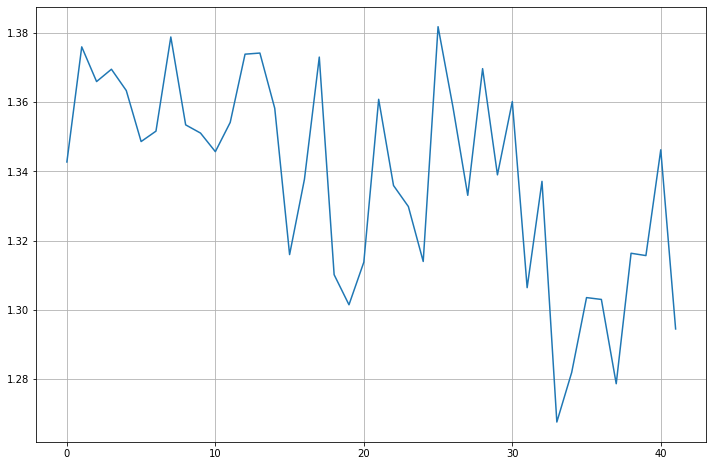

In [50]:
plt.figure(figsize=(12,8))
plt.plot(val_losses)
plt.grid()
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/hidden{model.num_hidden}_layers{model.num_layers}_{time.strftime("%Y%M%d%H%m",time.gmtime(time.time()))}_shakespeare.png')

## Save the model

In [51]:
# Save the trained model
model_name = f'/content/drive/MyDrive/Colab Notebooks/models/hidden{model.num_hidden}_layers{model.num_layers}_{time.strftime("%Y%M%d%H%m",time.gmtime(time.time()))}_shakespeare.net'
torch.save(model.state_dict(),model_name)

# Predictions

We will be geneting two functions, one function to generate the next character prediction and another one to generate strings of sentences.

## Load the model

In [ ]:
# MUST MATCH THE EXACT SAME SETTINGS AS MODEL USED DURING TRAINING!

model = CharModel(
    all_chars=all_characters,
    num_hidden=512,
    num_layers=3,
    drop_prob=0.5,
    use_gpu=True,
)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Final_Shakespeare.net'))
model.eval()

CharModel(
  (lstm): LSTM(84, 512, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_linear): Linear(in_features=512, out_features=84, bias=True)
)

## Prediction functions

In [52]:
def predict_next_char(model, char, hidden=None, k=1):

    # Encode the text
    encoded_text = model.encoder[char]

    # Convert to a numpy array with 1 observation of 1 feature [[x]]
    # to maintain the same dimensions
    encoded_text = np.array([[encoded_text]])

    # One-hot encode the character in a matrix of all characters
    encoded_text = one_hot_encoder(encoded_text,len(model.all_chars))

    # Convert to a tensor and load to GPU if required
    inputs = torch.from_numpy(encoded_text)
    if model.use_gpu:
        inputs = inputs.cuda()

    # Initialise the hidden states
    hidden = tuple([state.data for state in hidden])

    # Generate predictions
    lstm_out, hidden = model.lstm(inputs, hidden)

    # Pass through a softmax layer to generate probabilities
    probs = F.softmax(lstm_out, dim=1).data

    # Move probabilities back to CPU to use numpy
    if model.use_gpu:
        probs = probs.cpu()
    
    # Extract the top k probability items from the probabilities array
    probs, idx_pos = probs.topk(k)

    # Remove any axis of length one 
    idx_pos = idx_pos.numpy().squeeze()

    # Flatten the array to a one-dimensional array
    probs = probs.numpy().flatten()

    # Convert to probabilities per index
    probs = probs/probs.sum()

    # Randomly chose a character based on probabilities
    char = np.random.choice(idx_pos, p=probs)

    # Return the encoded value of the predicted char and the hidden state
    return model.decoder[char], hidden


In [53]:
def generate_text(model, size, seed='The', k=1):

    # Load model on gpu if required
    if model.use_gpu:
        model.cuda()
    else:
        model.cpu()

    # Set the model on evaluation mode
    model.eval()

    # Begin output from initial seed
    output_chars = [c for c in seed]

    # Initiate the hidden state
    hidden = model.hidden_state(batch_size=1)

    # Predict the next character for every character in seed
    for char in seed:
        char, hidden = predict_next_char(model, char, hidden, k=k)
    
    # Add initial characters to output
    output_chars.append(char)

    # Generate for required size
    for i in range(size):

        # Predict based off very last letter in output_chars
        char, hidden = predict_next_char(model, output_chars[-1], hidden, k=k)

        # Append predictex character
        output_chars.append(char)

    # Return the string of predicted text
    return ''.join(output_chars)

In [54]:
print(generate_text(model, 1000, seed='The ', k=3))

The bbbfAAbfbbAAAfAAffbbfAfbAfbAbAfbfAffAbAbAfAAfbfAbbfbfAbbfAfbfAAfbbbAAbfbfAAAAAAAfffbfbbfAfbfbAAbbAbAAAffbbAAAAAAbfAfAbbAAAfAfAAbfffAbAAAbAAbAfAAffbbbfAAbAbAfAAfAbbbAAbbAAbffAAfAbffbffAffAfAbbAbAbbAfbfAAbfbfbbbAffbffAAfbfbbAbAffbAbbAffbfbbfbbbAffbbfAbAfbAAAffbAfAbffAfbfbfffbbAfffbbAbAbAbbAfbbbbffAfAffbffAbAbbffbAfAfAfAfAfAAfAbAAffAffbbAAfAAbAfbfbAfbAfbbAffbAAbAAbffbAbAAfAbbbAffAAbbfAfbfAbbAbbfbffAffAAffAffffffbbAbbAfAfAAfAAAfAbfbAfAffAbfAAAffbbfAAfAAfbbfAffbbbAAfbfAbbAbAbbbbfAAbfAbfAbfbAbAbAfbbbfAbbfAfAAAAbbbbbAbAbAAfbbbfAbffffbAbAfbAbAbbAfbbAbAfffffffAffAbAbAAffbfbAAbfAbbbAbfAbfAAbffbffAfAfAbbAfAfffAfffbfbbAfAfffAfAAAfffffAbbAbAfAfbbfAfAbfbfbbAAfAfAfffAbfAAbbfbAbffbbAbbfbbfbAffffAbfAAAfAAbbAbbfbbbAffbfbAfAbbAAAfffffbbbbbAfAffbAbfAAbfAbAbfbbbfAbAAAfAfbffAAbbbffAbbbAfbfbAfAfffAAAffAAAfAAbbfAbffffAAbfffbbbAAbbAfAfbAbbbAbbAAAbbAffAbfffbbbAbfbbfbAAbAbfAfAbfAAAfbbAfbbffffAbfffbffbfbfffbffAAfbfbAAbfAfAAAbAfbAAAbbffbfffAfAbbAfbfbAAAbfbbbAbAbffffffbAbffbffbAfbAffbAfbfffbAbbbbAAfAbfbfbbAbbbf